## $\S$ 4.3.3. Reduced-Rank Linear Discriminant Analysis

The $K$ centroids in $p$-dimensional input space lie in an affine subspace of dimension $\le K-1$, and if $p \gg K$, then there will possibly be a considerable drop in dimension. Part of the popularity of LDA is due to such an additional restriction that allows us to view informative low-dimensional projections of the data.

Moreover, in locating the closest centroid, we can ignore distances orthogonal to this subspace, since they will contribute equally to each class. Thus we might just as well project the $X^*$ onto this centroid-spanning subspace $H_{K-1}$, and make distance comparisons there.

Therefore there is a fundamental dimension reduction in LDA, namely, that we need only consider the data in a subspace of dimension at most $K-1$. If  $K=3$, e.g., this could allow us to view the data in $\mathbb{R}^2$, color-coding the classes. In doing so we would not have relinquished any of the information needed for LDA classification.

### What if $K>3$? Principal components subspace

We might then ask for a $L<K-1$ dimensional subspace $H_L \subseteq H_{K-1}$ optimal for LDA in some sense. Fisher defined optimal to mean that the projected centroids were spread out as much as possible in terms of variance. This amounts to finding principal component subspaces of the centroids themselves ($\S$ 3.5.1, $\S$ 14.5.1).

In FIGURE 4.4 with the vowel data, there are eleven classes, each a different vowel sound, in a 10D input space. The centroids require the full space in this case, since $K-1=p$, but we have shown an optimal 2D subspace.

The dimensions are ordered, so we can compute additional dimensions in sequence. FIGURE 4.8 shows four additional pairs of coordinates, a.k.a. *canonical* or *discriminant* variables.

In summary then, finding the sequences of optimal subspaces for LDA involves the following steps:
* Compute the $K\times p$ matrix of class centroids $\mathbf{M}$  
the common covariance matrix $\mathbf{W}$ (for *within*-class covariance).
* Compute $\mathbf{M}^* = \mathbf{MW}^{-\frac{1}{2}}$ using the eigen-decomposition of $\mathbf{W}$.
* Compute $\mathbf{B}^*$, the covariance matrix of $\mathbf{M}^*$ ($\mathbf{B}$ for *between*-class covariance),  
and its eigen-decomposition $\mathbf{B}^* = \mathbf{V}^*\mathbf{D}_B\mathbf{V}^{*T}$.  
The columns $v_l^*$ of $\mathbf{V}^*$ in sequence from first to last define the coordinates of the optimal subspaces.
* Then the $l$th *discriminant variable* is given by  
\begin{equation}
Z_l = v_l^TX \text{ with } v_l = \mathbf{W}^{-\frac{1}{2}}v_l^*.
\end{equation}

In [1]:
"""FIGURE 4.8. Four projections onto pairs of canonical variates.

"""
import scipy
import scipy.linalg
import pandas as pd
import matplotlib.pyplot as plt

df_vowel = pd.read_csv('../data/vowel/vowel.train', index_col=0)
print('A pandas DataFrame of size {} x {} '
      'has been loaded.'.format(*df_vowel.shape))
df_vowel.head()

A pandas DataFrame of size 528 x 11 has been loaded.


,y,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,x.10
row.names,,,,,,,,,,,
1,1,-3.639,0.418,-0.670,1.779,-0.168,1.627,-0.388,0.529,-0.874,-0.814
2,2,-3.327,0.496,-0.694,1.365,-0.265,1.933,-0.363,0.510,-0.621,-0.488
3,3,-2.120,0.894,-1.576,0.147,-0.707,1.559,-0.579,0.676,-0.809,-0.049
4,4,-2.287,1.809,-1.498,1.012,-1.053,1.060,-0.567,0.235,-0.091,-0.795
5,5,-2.598,1.938,-0.846,1.062,-1.633,0.764,0.394,-0.150,0.277,-0.396


In [2]:
df_y = df_vowel.pop('y')
mat_x = df_vowel.as_matrix()
# df_vowel.head()

In [3]:
df_x_grouped = df_vowel.groupby(df_y)
size_class = len(df_x_grouped)
df_mean = df_x_grouped.mean()

# print(df_mean)
# print(df_vowel[df_y == 1].mean())

In [4]:
def within_cov(df_grouped: pd.DataFrame,
               df_mean: pd.DataFrame)->scipy.ndarray:
    """Compute the within-class covariance matrix"""
    size_class = len(df_grouped)
    dim = df_mean.columns.size
    mat_cov = scipy.zeros((dim, dim))
    n = 0
    
    for (c, df), (_, mean) in zip(df_grouped, df_mean.iterrows()):
        n += df.shape[0]
        mat_centered = (df - mean).as_matrix()
        mat_cov += mat_centered.T @ mat_centered
    return mat_cov/(n-size_class)

In [5]:
mat_M = df_mean.as_matrix()
mat_W = within_cov(df_x_grouped, df_mean)
vec_D, mat_U = scipy.linalg.eigh(mat_W)
# print(scipy.allclose(mat_U @ scipy.diag(vec_D) @ mat_U.T, mat_W))

mat_W_inv_sqrt = (mat_U @ scipy.diag(scipy.sqrt(scipy.reciprocal(vec_D))) @
                  mat_U.T)
mat_Mstar = mat_M @ mat_W_inv_sqrt    
vec_Mstar_mean = mat_Mstar.mean(axis=0)

mat_Mstar_centered = mat_Mstar - vec_Mstar_mean
mat_Bstar = mat_Mstar_centered.T @ mat_Mstar_centered/(mat_Mstar.shape[0]-1)

vec_DBstar, mat_Vstar = scipy.linalg.eigh(mat_Bstar)

mat_V = mat_W_inv_sqrt @ mat_Vstar
mat_x_canonical = mat_x @ mat_V

((528, 10), array([[ 0.12473971,  0.95678957,  2.62843231, ...,  0.60588044,
         -6.271087  , -3.8399905 ],
        [-0.07794737,  1.17521202,  2.1675939 , ...,  0.5308023 ,
         -6.12371191, -4.19728084],
        [ 0.24819092,  0.71300826,  1.61095419, ..., -1.26876038,
         -2.19229069, -2.80465088],
        ..., 
        [ 2.47988957,  0.72622574,  1.87063025, ..., -2.95008057,
         -3.67386651, -7.6457543 ],
        [ 0.94046604,  1.03336666,  1.46131355, ..., -4.0835249 ,
         -2.87553634, -8.52601279],
        [ 0.52898019,  0.21058282, -0.72053164, ..., -3.32504631,
         -4.92573018, -5.60206861]]))

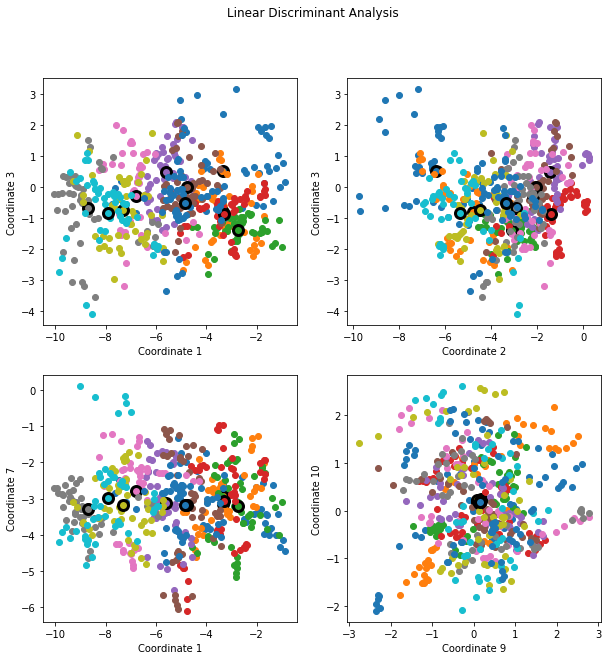

In [6]:
fig48 = plt.figure(0, figsize=(10, 10))

ax11 = fig48.add_subplot(2, 2, 1)
ax12 = fig48.add_subplot(2, 2, 2)
ax21 = fig48.add_subplot(2, 2, 3)
ax22 = fig48.add_subplot(2, 2, 4)

for y in range(1, size_class+1):
    mat_x_grouped = mat_x_canonical[df_y == y]
    c = next(ax11._get_lines.prop_cycler)['color']
    ax11.plot(mat_x_grouped[:, -1], mat_x_grouped[:, -3], 'o', color=c)
    ax12.plot(mat_x_grouped[:, -2], mat_x_grouped[:, -3], 'o', color=c)
    ax21.plot(mat_x_grouped[:, -1], mat_x_grouped[:, -7], 'o', color=c)
    ax22.plot(mat_x_grouped[:, -9], mat_x_grouped[:, -10], 'o', color=c)
    
    vec_centroid = mat_x_grouped.mean(axis=0)
    ax11.plot(vec_centroid[-1], vec_centroid[-3], 'o', color=c,
              markersize=10, markeredgecolor='black', markeredgewidth=3)
    ax12.plot(vec_centroid[-2], vec_centroid[-3], 'o', color=c,
              markersize=10, markeredgecolor='black', markeredgewidth=3)
    ax21.plot(vec_centroid[-1], vec_centroid[-7], 'o', color=c,
              markersize=10, markeredgecolor='black', markeredgewidth=3)
    ax22.plot(vec_centroid[-9], vec_centroid[-10], 'o', color=c,
              markersize=10, markeredgecolor='black', markeredgewidth=3)
    
ax11.set_xlabel('Coordinate 1')
ax11.set_ylabel('Coordinate 3')
ax12.set_xlabel('Coordinate 2')
ax12.set_ylabel('Coordinate 3')
ax21.set_xlabel('Coordinate 1')
ax21.set_ylabel('Coordinate 7')
ax22.set_xlabel('Coordinate 9')
ax22.set_ylabel('Coordinate 10')
fig48.suptitle('Linear Discriminant Analysis')
plt.show()

### Maximize between-class variance relative to within-class

Fisher arrived at this decomposition via a different route, without referencing to Gaussian distributions at all. He posed the problem:

> Find the linear combination $Z=a^TX$ such that the between-class variance is maximized relative to the within-class variance.

FIGURE 4.9 shows why this criterion makes sense. Although the direction joining the centroids separates the means as much as possible (i.e., maximizes the between-class variance), there is considerable overlap between the projected classes due to the nature of the covariances. By taking the covariance into account as well, a direction with minimum overlap can be found.

The between-class variance of Z is $a^T\mathbf{B}a$ and the within-class variance $a^T\mathbf{W}a$ and the *total* covariance $\mathbf{T} = \mathbf{B} + \mathbf{W}$, ignoring class information. Then Fisher's problem  amounts to maximizing the *Rayleigh quotient*,

\begin{equation}
\max_a \frac{a^T\mathbf{B}a}{a^T\mathbf{W}a},
\end{equation}

or equivalently

\begin{equation}
\max_a a^T\mathbf{B}a \text{ subject to } a^T\mathbf{W}a = 1.
\end{equation}

This is a generalized eigenvalue problem, with $a$ given by the largest eigenvalue of $\mathbf{W}^{-1}\mathbf{B}$.

### Algorithm for the generalized eigenvalue problem

It is not hard to show (Exercise 4.1) the followings.
1. The optimal $a_1$ is identical to $v_1$ defined above.
2. Similarly one can find the next direction $a_2$, orthogonal in $\mathbf{W}$ to $a_1$, such that $a_2^T\mathbf{B}a_2/a_2^T\mathbf{W}a_2$ is maximized; the solution is $a_2 = v_2$, and so on.

The $a_l$ are referred to as *discriminant coordinates* or *canonical variates*, since an alternative derivation of these results is through a canonical correlation analysis of the indicator response matrix $\mathbf{Y}$ on the predictor matrix $\mathbf{X}$ ($\S$ 12.5).

### Summary

* Gaussian classification with common covariance leads to linear decision boundaries. Classficiation can be achieved by sphering the data w.r.t. $\mathbf{W}$, and classifying to the closest centroid (modulo $\log\pi_k$) in the sphered space.
* Since only the relative distances to the centroids count, one can confine the data to the subspace spanned by the centroids in the sphered space.
* This subspace can be further decomposed into successively optimal subspaces in terms of centroid separation. This decomposition is identical to the decomposition due to Fisher.

### Dimension reduction for classification

The reduced subspaces have been motivated as a data reduction (for viewing) tool. Can they also be used for classification, and what is the rationale?

Clearly they can, as in our original derivation; we simply limit the distance-to-centroid calculations to the chosen subspace. One can show that this is a Gaussian classfication rule with the additional restriction that the centroids of the Gaussian lie in a $L$-dimensional subspace of $\mathbb{R}^p$. Fitting such a model by maximum likelihood, and then constructing the posterior probabilities using Bayes' theorem amounts to the classification rule described above (Exercise 4.8).

### Impact of prior information $\pi_k$

Gaussian classification dictates the $\log\pi_k$ correction factor in the distance calculation. The reason for this correction can be seen in FIGURE 4.9. The misclassfication rate is based on the area of overlap between the two densities. If the $\pi_k$ are equal, then the optimal cut-point is midway between the projected means. If not equal, moving the cut-point toward the *smaller* class will improve the error rate. One can derive the linear rule using LDA (or any other method), and then choose the cut-point to minimize misclassification error over the training data.

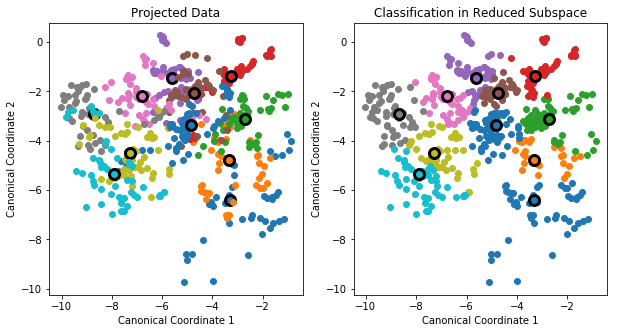

In [19]:
"""FIGURE 4.11. The decision boundaries for the classifier based on the 2D
LDA solution.

As an example of the benefit of the reduced-rank restriction, we return to
the vowel data with 11 classes and 10 variables, and hence 10 possible
dimensions for the classifier.
"""
fig411 = plt.figure(1, figsize=(10, 5))

ax1 = fig411.add_subplot(1, 2, 1)
ax2 = fig411.add_subplot(1, 2, 2)

mat_centroid2d = []
for y in range(1, size_class+1):
    mat_x2d_grouped = mat_x_canonical[df_y == y][:, -1:-3:-1]
    c = next(ax1._get_lines.prop_cycler)['color']
    ax1.plot(mat_x2d_grouped[:, 0], mat_x2d_grouped[:, 1], 'o', color=c)
    
    vec_centroid2d = mat_x2d_grouped.mean(axis=0)
    mat_centroid2d.append(vec_centroid2d)
    ax1.plot(vec_centroid2d[0], vec_centroid2d[1], 'o', color=c,
             markersize=10, markeredgecolor='black', markeredgewidth=3)

mat_centroid2d = scipy.array(mat_centroid2d)
vec_classified = scipy.array([
    ((mat_centroid2d - vec_x)**2).sum(axis=1).argmin()
    for vec_x in mat_x_canonical[:, -1:-3:-1]
])
for y, centroid in enumerate(mat_centroid2d):
    mat_x2d_classified = mat_x_canonical[vec_classified == y][:, -1:-3:-1]
    c = next(ax2._get_lines.prop_cycler)['color']
    ax2.plot(mat_x2d_classified[:, 0], mat_x2d_classified[:, 1], 'o',
             color=c)
    ax2.plot(centroid[0], centroid[1], 'o', color=c,
             markersize=10, markeredgecolor='black', markeredgewidth=3)

ax1.set_xlabel('Canonical Coordinate 1')
ax1.set_ylabel('Canonical Coordinate 2')
ax1.set_title('Projected Data')
ax2.set_xlabel('Canonical Coordinate 1')
ax2.set_ylabel('Canonical Coordinate 2')
ax2.set_title('Classification in Reduced Subspace')
plt.show()

### Connection between Fisher's reduced-rank discriminant analysis and regression of an indicator response matrix

It turns out that LDA amounts to the regression followed by an eigen-decomposition of $\hat{\mathbf{Y}}^T\mathbf{Y}$. In the case of two classes, there is a single discriminant variable that is identical up to a scalar multiplication to either of the columns of $\hat{\mathbf{Y}}$. A related fact is that if one transforms the original predictors $\mathbf{X}$ to $\hat{\mathbf{Y}}$, then LDA using $\hat{\mathbf{Y}}$ is identical to LDA in the original space (Exercise 4.3).